In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import time

In [2]:
import os
os.chdir('..')
import rwpropa as rw

Propagator initialized
Propagator initialized
Propagator initialized


In [3]:
from pathlib import Path
path_figs = 'comparison/compact_sources_1e17m/figures'
path_data = 'comparison/compact_sources_1e17m/data'
path_data_raw = 'comparison/compact_sources_1e17m/data/raw_data'
Path(path_figs).mkdir(parents=True, exist_ok=True)
Path(path_data).mkdir(parents=True, exist_ok=True)
Path(path_data_raw).mkdir(parents=True, exist_ok=True)

### "Compact" astrophysical sources

Charged particles (comsic rays (CRs)) are accelerated to high energies in astrophysical sources until the gyration radius exceeds the system size according to the Hillas criterion and the CRs can no longer be confined by the accelerator. Since strong magnetic fields with a significant amount of turbulence typically prevail in these sources, the description of particle propagation in the sources is nontrivial and complicate the analytical description of transport. 

Simulations are used for describing as accurately as possible the particle transport that has an impact on numerous observable mulstimessenger signatures. In the following, we focus on the transport properties in these sources, which are described by the diffusion coefficient (see the introductions in the previous tutorials).

There are numerous possible sources covering a large parameter space of physical properties relevant to particle transport. For the comparison between RW and CR, we use typical parameters used in the literature for AGN plasmoids:
- isotropic 3d Kolmogorov turbulence
- magnetic field strength: 1 Gaus
- correlation length turbulence: $\sim10^{11}$ m
- particle energies: 100 PeV

In [4]:
l_c = 1.05*10**11 # [m]
energy = 10**17 # [eV]

These parameters will result in gyroradii of the charged CRs:
\begin{align}
r_\mathrm{g} = \frac{E}{q\,c\,B} = \frac{100\,\mathrm{PeV}}{q\,c \cdot 1\mathrm{G}} \approx 3.34\cdot10^{12}\,\mathrm{m}.
\end{align}

In [5]:
r_g = 3.34*10**12 # [m]

Particles are in the quasi-ballistic transport regime ($r_\mathrm{g} \gg l_\mathrm{c}$), where they experience only minor deflections. The expected diffusion coefficient $\kappa$ is (see e.g. Subedi, P. et al. 2017, ApJ, 837, 140. doi:10.3847/1538-4357/aa603a):
\begin{align}
\kappa_\mathrm{theory} = \frac{r_\mathrm{g}^2 \cdot c}{2l_\mathrm{c}} = \frac{(3.34\cdot10^{12}\,\mathrm{m})^2 \cdot c}{2\cdot 1.05 \cdot 10^{11}\,m} \approx 1.59\cdot10^{23}\,\frac{\mathrm{m^2}}{\mathrm{s}}.
\end{align}

In [6]:
kappa_theory = 1.59*10**23 # [m^2/s]

This theoretical diffusion coefficient serves as an input for the RWPropa simulation and as a reference for the numerical simulations.

This diffusion coefficient results in expected mean-free paths of
\begin{align}
\lambda_\mathrm{theory} = \frac{3 \kappa_\mathrm{theory}}{c} \approx 1.6\cdot10^{15}\,\mathrm{m}.
\end{align}
Particles become diffusive at trajectory lengths of about $\lambda$, which is why we stop the simulations after trajectory lengths of $10^{17}$ to have some buffer and a clear plateau in the running diffusion coefficients.

In [7]:
lambda_theory = 1.6*10**15 # [m]
traj_max = 10**17 # [m]

### Simulations with CRPropa
CRPropa is a state of the art propagation code that can propagate CRs by solving both the equation of motion (ballistic) and the transport equation (diffusive) in arbitrary magnetic fields. 

#### Installation
Following the installation of CRPropa in a virtuelenv as described in https://crpropa.github.io/CRPropa3/pages/Installation.html

#### Simulation
Run the **simulation script** *comparison/crp_sim_compact_sources_1e17m.py* in your CRPropa environment:
This starts 15 simulations with varying step sizes of the integration routine. This convergence test is necessary to find the required resolution (step size) of the simulation routine that solves the equation of motion. The simulation results are evaluated by determining the diffusion coefficients, which provide a statistical description of the transport. 

Run the script with prop_module = 'CK', 'BP', and 'SDE' to get the results for all available CRPropa propagation modules.

#### Simulation results
The raw data (position, momentum,..) of the simulations are stored in *path_data_raw* (default is */comparison/data/raw_data*). The analyzed data (diffusion coefficients, simulation time,..) are stored in *path_data* (default is */comparison/data*) and will be used in the following. 

### Simulations with RWPropa
In the following we perform the same simulations as in CRPropa with RWPropa.

In [13]:
step_sizes = np.logspace(10, 15, 15) # [m]

In [24]:
df_sim_data = pd.DataFrame(columns=('step_size', 'time', 'kappa', 'kappa_err'))

fig = plt.figure(figsize=(5,3.5))
# start with large step sizes first, as these simulations are faster
step_sized_reversed = np.insert(step_sizes[::-1], 0, step_sizes[-1], axis=0)
for i, step_size in enumerate(step_sized_reversed):
    print('______________________________________________________________')
    print('step_size: ', step_size)
    nr_steps = int(traj_max/step_size)
    sim = rw.IsotropicSimulation(nr_particles = 10**3, energy = energy, step_size = step_size, nr_steps = nr_steps, diffusion_coefficient_para = kappa_theory, nr_obs_steps = 100)
    file_name = path_data_raw+'/rwpropa_'+str(step_size/10**11)
    start_time = time.process_time()
    %time sim.simulate(file_name)
    time_needed = time.process_time() - start_time
    print('time needed: ', time_needed, 's')
    df = pd.read_pickle(file_name+'.pkl')
    sta = rw.Statistics(df)
    df_kappas = sta.get_diffusion_coefficients()
    if i == 0:
        print('______________________________________________________________')
        print('Finished setup test - starting now with the convergence test!')
        continue
    df_sim_data.loc[i-1] = [step_size, time_needed, np.mean(df_kappas['kappa'][-10:]), np.std(df_kappas['kappa'][-10:])]
    plt.plot(df_kappas['l'], (df_kappas['kappa']))
    file_name = path_data+'/sim_result_rwp_'
    np.save(file_name+str(step_size/10**11)+'_l.npy', np.array(df_kappas['l']))
    np.save(file_name+str(step_size/10**11)+'_kappa.npy', np.array(df_kappas['kappa']))

plt.loglog()
file_name_results = path_data+'/rwp_sim_data.pkl'
df_sim_data.to_pickle(file_name_results)

______________________________________________________________
step_size:  1000000000000000.0
mfp_ios 1591060707138092.0
simulate with a diffusion coefficient of  1.59e+23 m²/s
start simulation
Propagator initialized
Observer initialized
saved data file comparison/compact_sources_1e17m/data/raw_data/rwpropa_10000.0.pkl
CPU times: user 18.3 s, sys: 89.6 ms, total: 18.4 s
Wall time: 18.4 s
time needed:  18.36454436400001 s
init statistics plotting class
______________________________________________________________
Finished setup test - starting now with the convergence test!
______________________________________________________________
step_size:  1000000000000000.0
mfp_ios 1591060707138092.0
simulate with a diffusion coefficient of  1.59e+23 m²/s
start simulation
Propagator initialized
Observer initialized
saved data file comparison/compact_sources_1e17m/data/raw_data/rwpropa_10000.0.pkl
CPU times: user 1.67 s, sys: 28.1 ms, total: 1.69 s
Wall time: 1.7 s
time needed:  1.6956109699999

KeyboardInterrupt: 

time needed:  7.5876904030000105 s
init statistics plotting class
______________________________________________________________
step_size:  7196856730011.528
mfp_ios 1591060707138092.0
simulate with a diffusion coefficient of  1.59e+23 m²/s
start simulation
Propagator initialized
Observer initialized


KeyboardInterrupt: 

time needed:  0.2943872209999938 s
init statistics plotting class


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fd86e580790> (for post_execute):


KeyboardInterrupt: 

## Comparison of simulation results

In [29]:
comparison = rw.Comparison(kappa_theory, lambda_theory, step_sizes, l_c, r_g, path_data_raw, path_data, path_figs)

### Running diffusion coefficients

**TODO** add theory for small lines: kappa(t) ~ t

no data for CK
no data for SDE


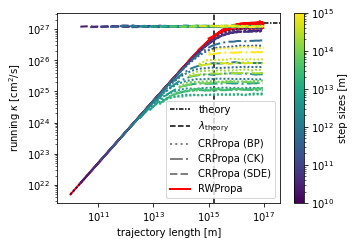

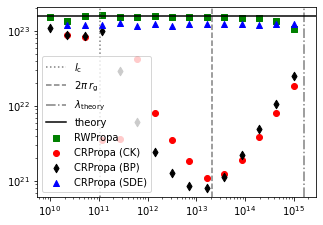

In [26]:
comparison.plot_running_diffusion_coefficients()

Note that the color-code (cc) is only used for running diffusion coefficients simulated with CRPropa, as the ones simulated with RWPropa overlay (see red lines) -> the differences in the step sizes are not visible.

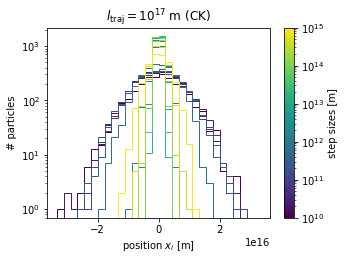

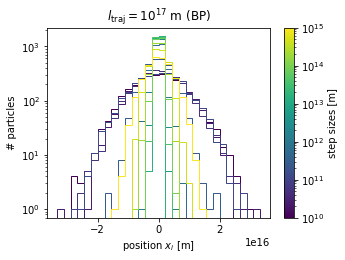

error while loading data with step size:  10000000000.0
error while loading data with step size:  22758459260.74791
error while loading data with step size:  51794746792.31202
error while loading data with step size:  117876863479.35866
error while loading data with step size:  268269579527.97272


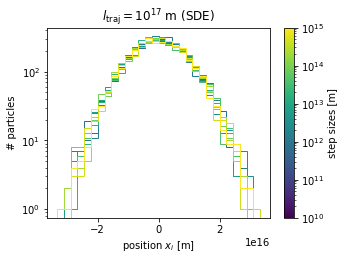

In [11]:
unit = 'Mpc' # unit of output of CRPropa
comparison.plot_particle_distributions(prop_type='CK', unit=unit)
comparison.plot_particle_distributions(prop_type='BP', unit=unit)
comparison.plot_particle_distributions(prop_type='SDE', unit=unit)

7.205759403792794e+16
12000


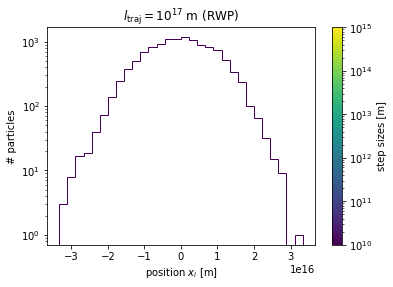

In [12]:
prop_type = 'RWP'
unit = 'm'
for i, step_size in enumerate(step_sizes[:1]):

    data = pd.read_pickle(path_data_raw+'/rwpropa_'+str(step_size/10**11)+'.pkl')
    data = data.sort_values('d')
    max_l = max(data['d'].values.tolist())
    print(max_l)
    data = data[data['d'] == max_l]        
    bins = 10
    color = plt.cm.viridis(np.linspace(0, 1, len(step_sizes))[i])
    xs = np.array(data.x.values.tolist())
    ys = np.array(data.y.values.tolist())
    zs = np.array(data.z.values.tolist())
    print(len(np.concatenate((xs,ys,zs))))
    if unit == 'Mpc':
        scale = 3.086e22
    else:
        scale = 1
    plt.hist(np.concatenate((xs,ys,zs), axis=None)*scale, bins=30, range=[-1e17/3, 1e17/3], histtype=u'step', edgecolor=color, linewidth=1., facecolor="None")
    
# colorbar
plt.scatter(np.zeros(len(step_sizes)), np.zeros(len(step_sizes)), c=step_sizes, cmap='viridis', norm=matplotlib.colors.LogNorm())
plt.colorbar(label='step sizes [m]')

plt.xlabel('position $x_i$ [m]')
plt.ylabel('# particles')
plt.title('$l_\mathrm{traj} = 10^{17}$ m ('+prop_type+')')

plt.yscale('log')
plt.show()

### Convergence tests of diffusion coefficients

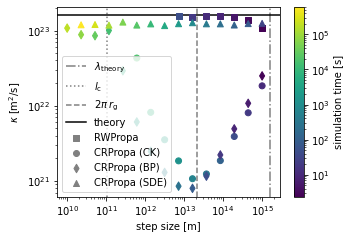

In [27]:
comparison.plot_kappa_convergence_tests()

For RWPropa SImulations, the step size shown here does not appear to have a noticeable effect on the diffusion coefficients. The steps can be significantly larger than the correlation length of the turbulence and than the gyration radius of the particles. This is not surprising, since in the correlated random walk in Cartesian coordinates used in RWPropa for isotropic turbulence, the gyration motion and the turbulence does not need to be resolved.

For CRPropa, on the other hand, the resolution plays a significant role in the integration of the particle trajectories. Only for small step sizes, when both the relevant scales of turbulence and gyration motion are resolved, does the diffusion coefficient converge against the prediction of the theory. As soon as the step size becomes larger than the correlation length of the turbulence, diffusion coefficients are wrong. See the appendix in Reichherzer 2020 for a detailed discussion of this effect. If the step size is larger than the gyroradius, the diffusion coefficients increase again, because now averaging over the large steps becomes too large.

Note that the BP and CK simulation results obtained with CRPropa should be averaged over different realisations of the turbulence generated with the PlaneWaveTurbulence module, which would further increase the simulation time. At least 100 realizations are needed to become reasonable good simulation results. This would increase the simulation tiems by an additional factor of 100!

Also note that for BP and CK, the simulation time is a lower boundary, as only 250 modes, which is the minimum for the applied fluctuation wavelength range (Schlegel et al. 2020), are used and the simulation time scales linearly with the number of modes.

### Comparison of simulation times

Further plots to visualize different aspects of the comparison.

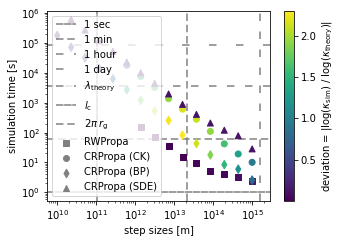

In [30]:
comparison.plot_time_vs_steps_deviation()

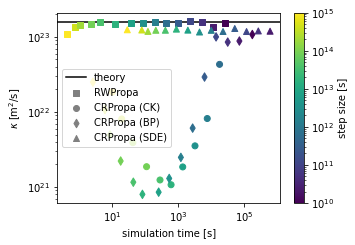

In [23]:
comparison.plot_kappa_vs_time_steps()

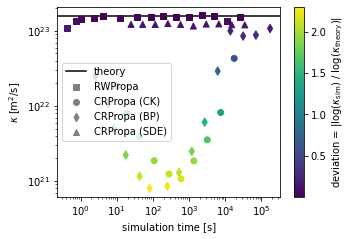

In [16]:
comparison.plot_kappa_vs_time_deviation()

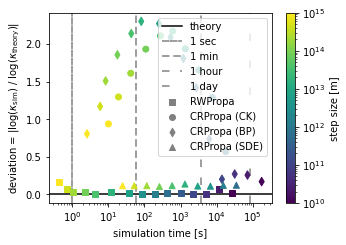

In [17]:
comparison.plot_deviation_vs_time_steps()

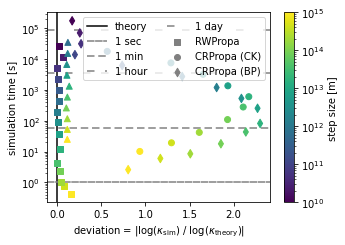

In [18]:
comparison.plot_time_vs_deviation_steps()

In [ ]:
for (size_t i = 0; i <= numb; i++) {
			double time = min * pow(dist / min, i / (numb - 1.0));
			addTime(time);
		}

0 10
5.0
1 10
6.974753969812105
2 10
9.729438587881944
3 10
13.572088082974531
4 10
18.932395047073236
5 10
26.40975950252502
6 10
36.84031498640386
7 10
51.39042664010975
8 10
71.68711644368864
9 10
100.0
[5.0, 6.974753969812105, 9.729438587881944, 13.572088082974531, 18.932395047073236, 26.40975950252502, 36.84031498640386, 51.39042664010975, 71.68711644368864, 100.0]
[  5.           6.97475397   9.72943859  13.57208808  18.93239505
  26.4097595   36.84031499  51.39042664  71.68711644 100.        ]


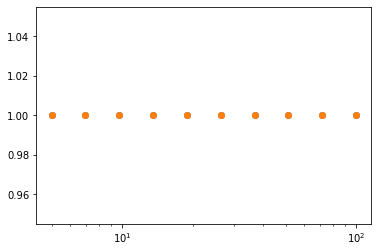

In [30]:
numb = 10
m = 5
dist = 100
logs = []
for i in range(0, numb):
    print(i, numb)
    time = m * np.power(dist / m, i / (numb - 1.0))
    print(time)
    logs.append(time)
    
logs_np = np.logspace(np.log10(m), np.log10(dist), numb)
print(logs)
print(logs_np)
plt.scatter(logs, np.ones(numb))
plt.scatter(logs_np, np.ones(numb))
plt.xscale('log')